# Introduction:

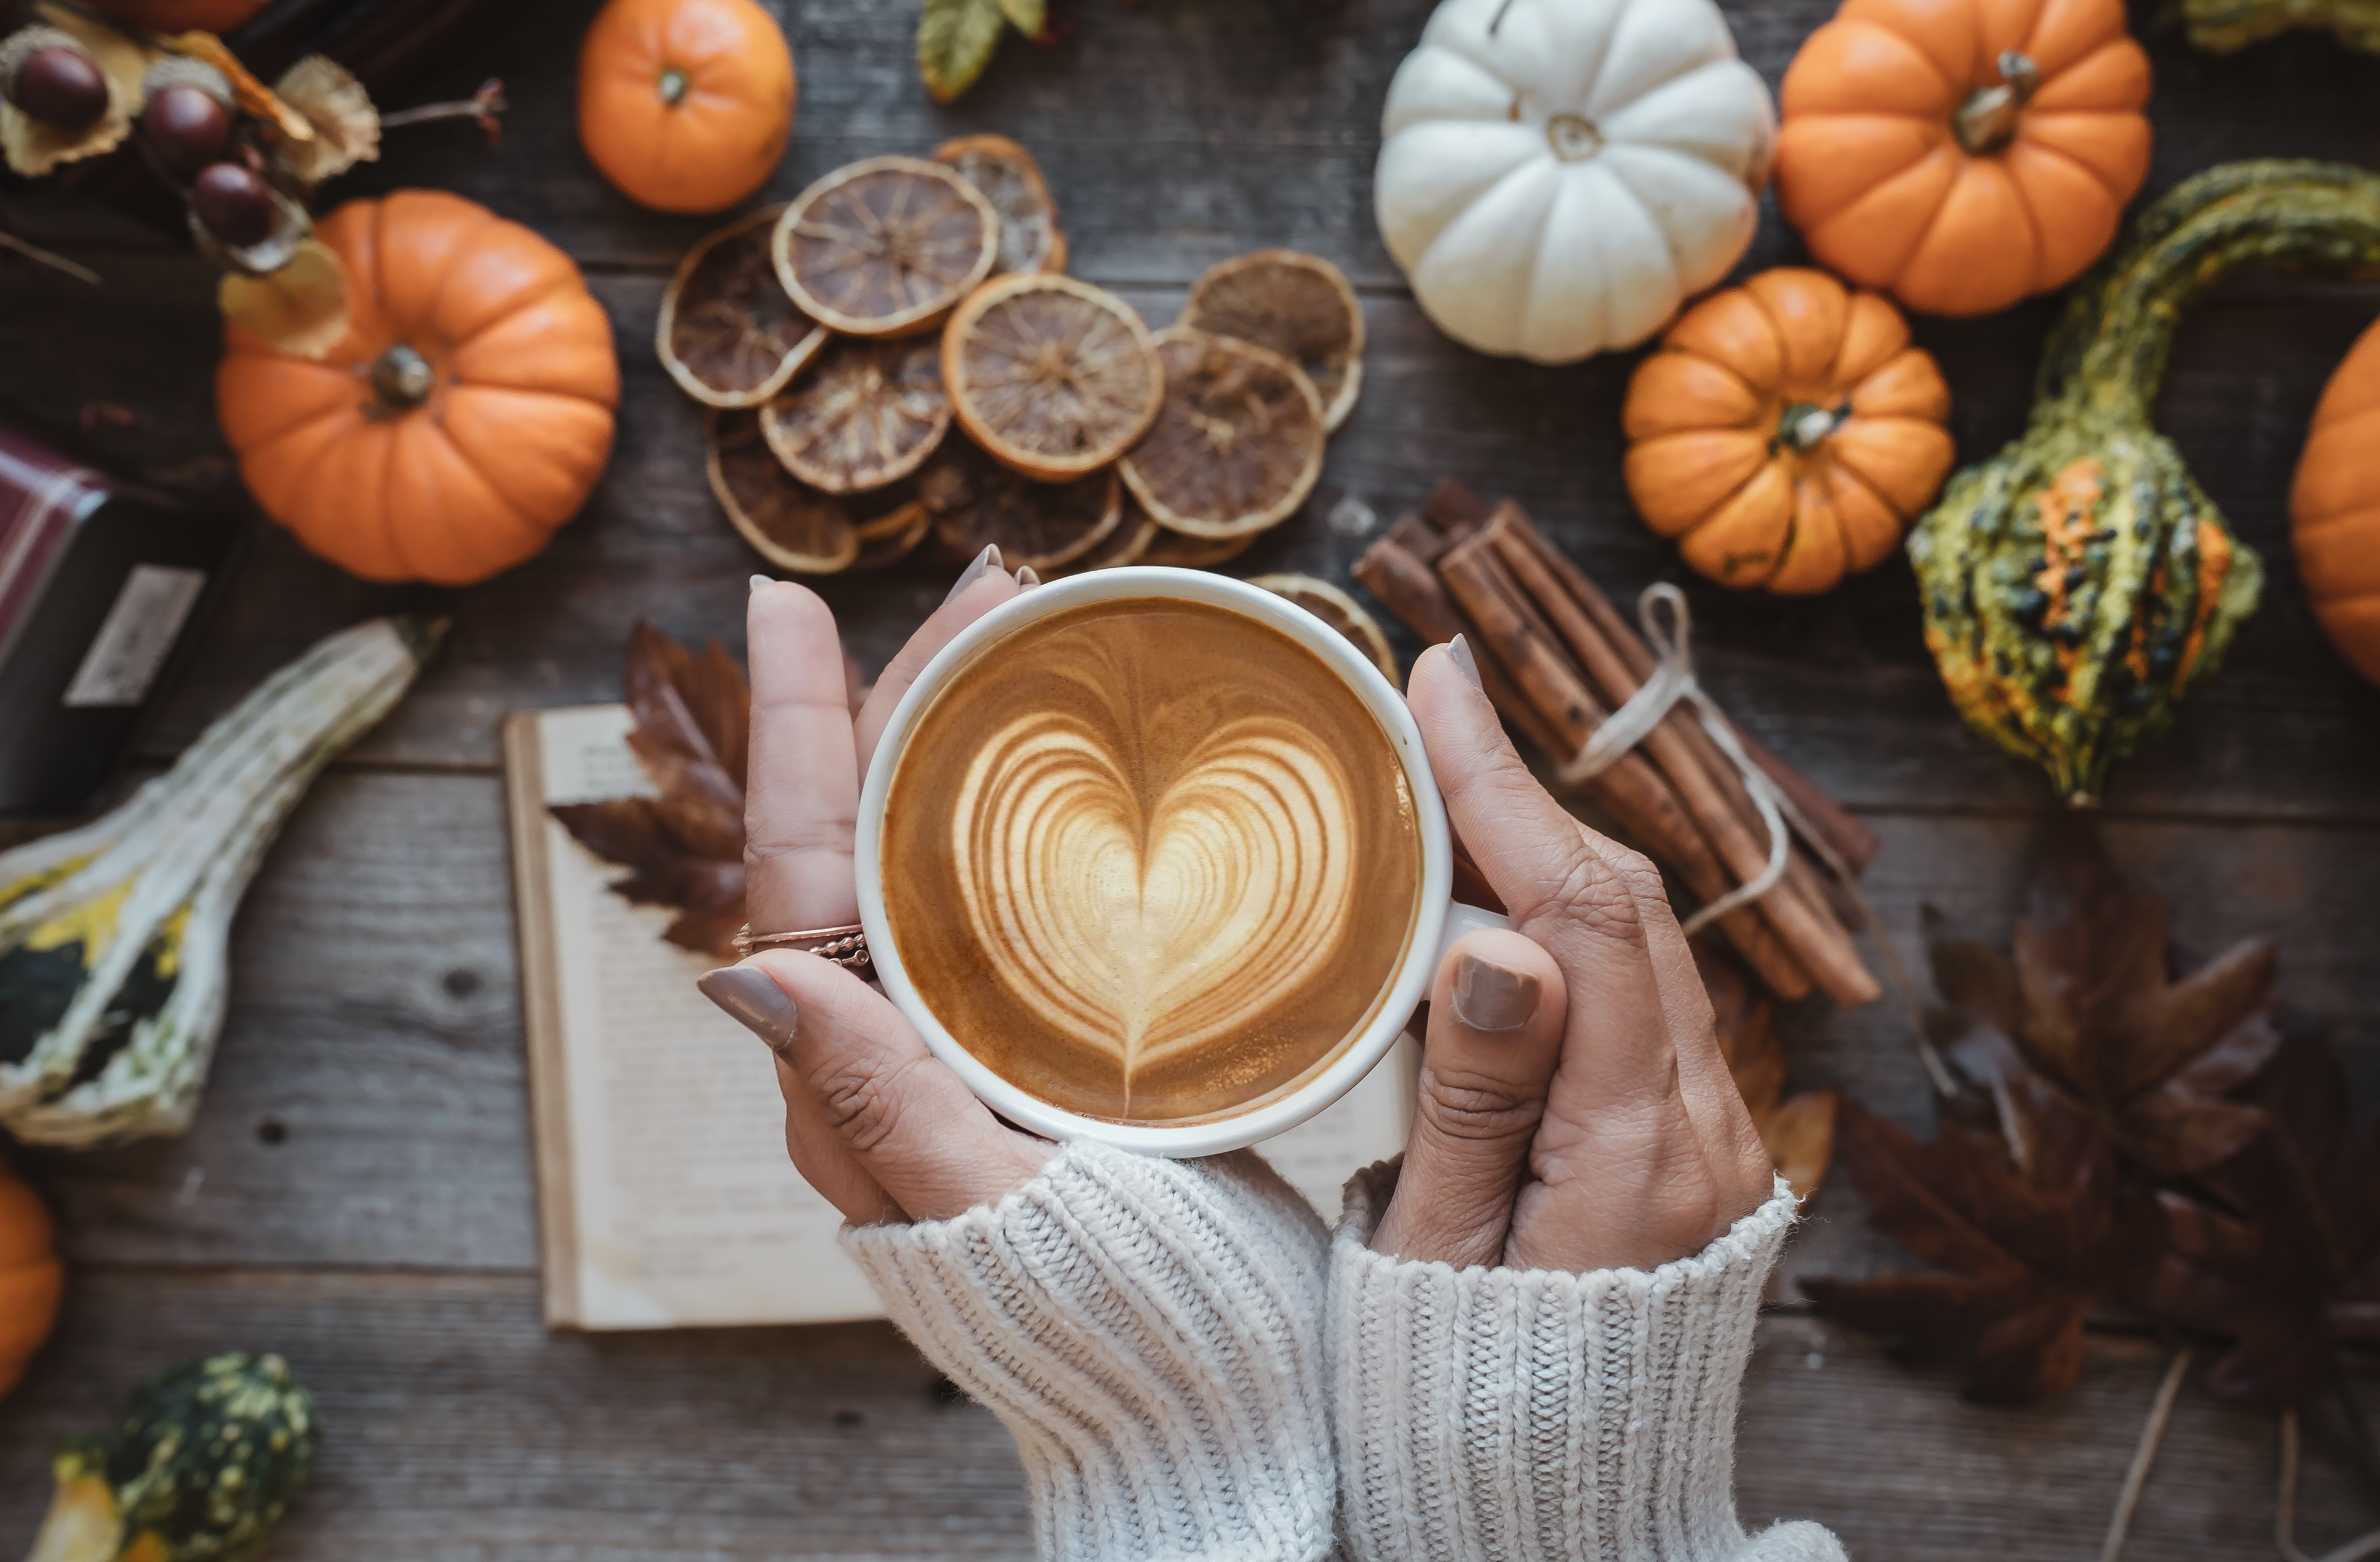

Photo by <a href="https://unsplash.com/@prachipalwe?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Prchi Palwe</a> on <a href="https://unsplash.com/photos/ZlSIjc_sPQ4?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

To study different statistical models for predictive use in the search term "Pumkin Spice" on Google. I used data from Google Trends from the last 5 years. I will validate my predictions on a rolling basis for a double blind validation. Train/test split will be 80%/20%. 

Hypothesis: Pumkin Spice is going to have strong seasonality, since it's associated with American Fall Holidays and seasonal food dishes. I can build a model to predict it's popularity that will perform better than either using last week's or last month's data. 

Null hypothesis: Using last week's data or last year's data will be more performative to predict this week's level of popularity for the search term "Pumpkin Spice." 

Data: 5 year pull and export from Google Trends on 10/7/2023 to a csv. 

Disclaimers: I'll be using the term SARIMA as an umbrella term to mean any combination of seasonality, auto regressive terms, first differencing and/or moving average. However many of the models I will try won't have all of these components. SARIMA as a term will be used inclusinvely for the family of linear model. 

Feedback: I welcome feedback about my notebook, model or process. Please reach out to me via my linkedin if you have any positive or contructive feedback. I'm open to encorporating your perspective. https://www.linkedin.com/in/louis-casanave-78057aa0/ 

In [1]:
import statsmodels                                            # our basic linear model library
import statsmodels.tsa.api as tsa                             # specificly for time series analysis
import pandas as pd                                           # for our data
import matplotlib.pyplot as plt                               # visualizing
import seaborn as sns                                         # visualizing with a better API
import pmdarima as pm                                         # gridsearch for sarima variables
import numpy as np                                            # because we have to 
from pmdarima.arima.utils import ndiffs                       # to test statistical first differenceing
from sklearn.metrics import mean_absolute_percentage_error    # an easy to understand, common accuracy metric
from sklearn.metrics import mean_squared_error                # a better accuracy metric 
from statsmodels.tsa.seasonal import seasonal_decompose       # for analysis, produces plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for tuning the model, produces plots
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # for trying an ETS model
import pickle                                                 # for saving our model
import warnings                                               # for getting rid of warnings 

from seasonal_mod import *

## A warning about supressing warnings:

##### I have run all the code in this notebook once and am supressing all the warnings for output readability, since I know these warnings are harmless and only indicative of a less-than-performant model. I am only removing warnings after I have finalized the code in my notebook. I do not recomend removing all warnings on code you (yourself) have not run before on your own machine. Remove warnings at your own risk! 

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('pumpkin_spice_5_years.csv')                 #loading the file and remormatting to something usable
df.reset_index(inplace = True)                     
df.drop(0, inplace= True)
df.columns = ['date', 'count']
df['date'] = pd.to_datetime(df['date'])
df['count'] = pd.to_numeric(df['count'])
df.set_index('date', inplace = True)
df.head()

,count
date,
2018-10-14,47
2018-10-21,41
2018-10-28,37
2018-11-04,26
2018-11-11,28


In [4]:
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(df['count'], test='adf')                       
# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(df['count'], test='kpss')                     
# Or a PP test:
n_pp = ndiffs(df['count'], test='pp')

print(n_adf, n_kpss, n_pp)                                    # Print all results

0 0 0


Observations: no statistical test thinks I should take a first difference. 

In [5]:
df = df.resample('W').sum()                                   # Ensuring a datetime index

<Axes: xlabel='date'>

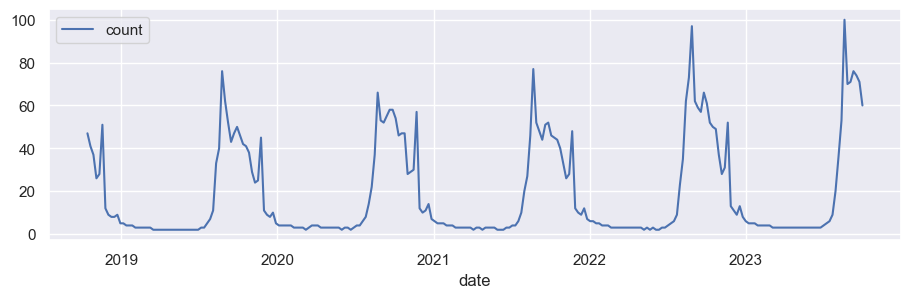

In [6]:
sns.set(rc={'figure.figsize':(11,3)})                         # Reformatting the plot   
sns.lineplot(df)                                              # Taking a look at the raw data

Each year has a simmilar lower dip, however the upper range each year during what is presumably fall: we get an increasingly dramatic spike (except for 2020, which makes sence given the pandemic.) There is a trend in the upper threshold of the data each year. Pumpkin spice was a more popular search term in 2022 then the year before, and this year looks to outdo last year. 

#### Seasonal Decomposition 

Method: 
1) additive: it's more common of a pattern, want to rule it out
2) multiplicative: it matches the upper bounds trend better 

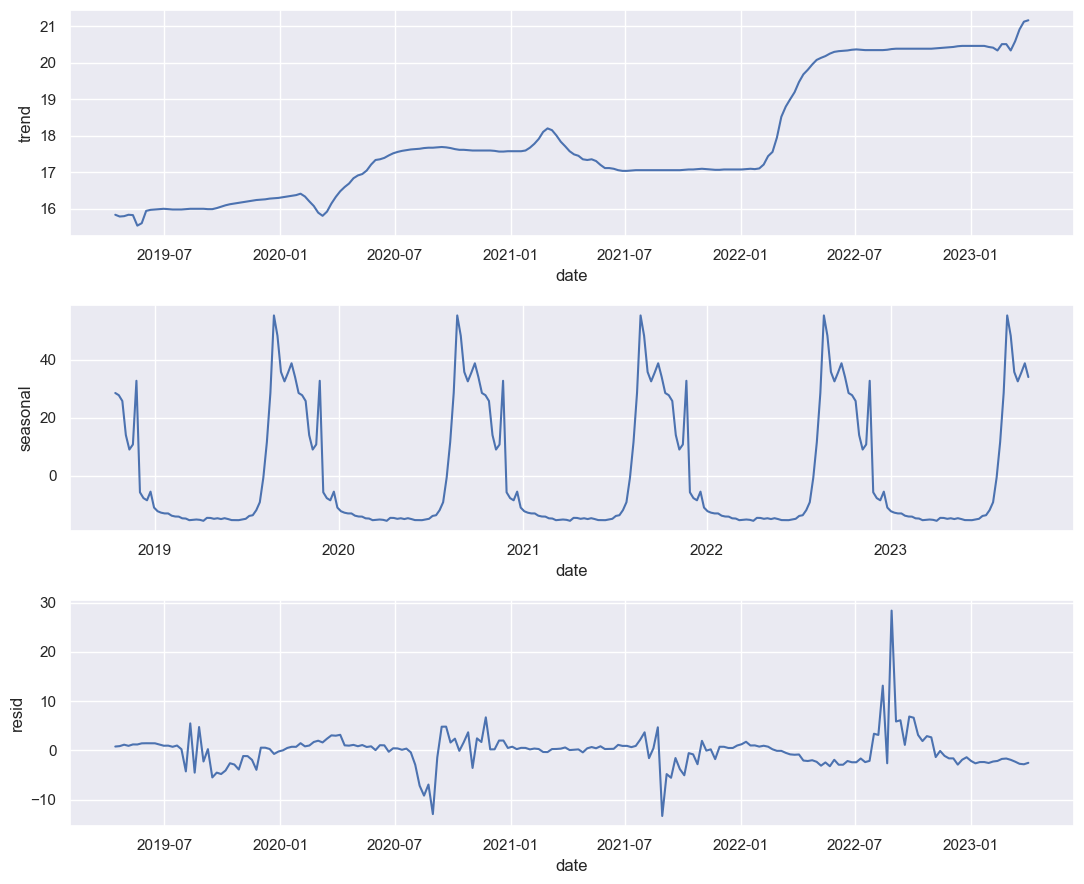

In [7]:
seasonal_decomp(df, 'additive')                                       # Trying an additive model first, although I think a multiplicative model will suit better

Observations: the residuals are not random, they have a seasonality as well with the additive model, a good way to know we should definately try a multiplicative model. 

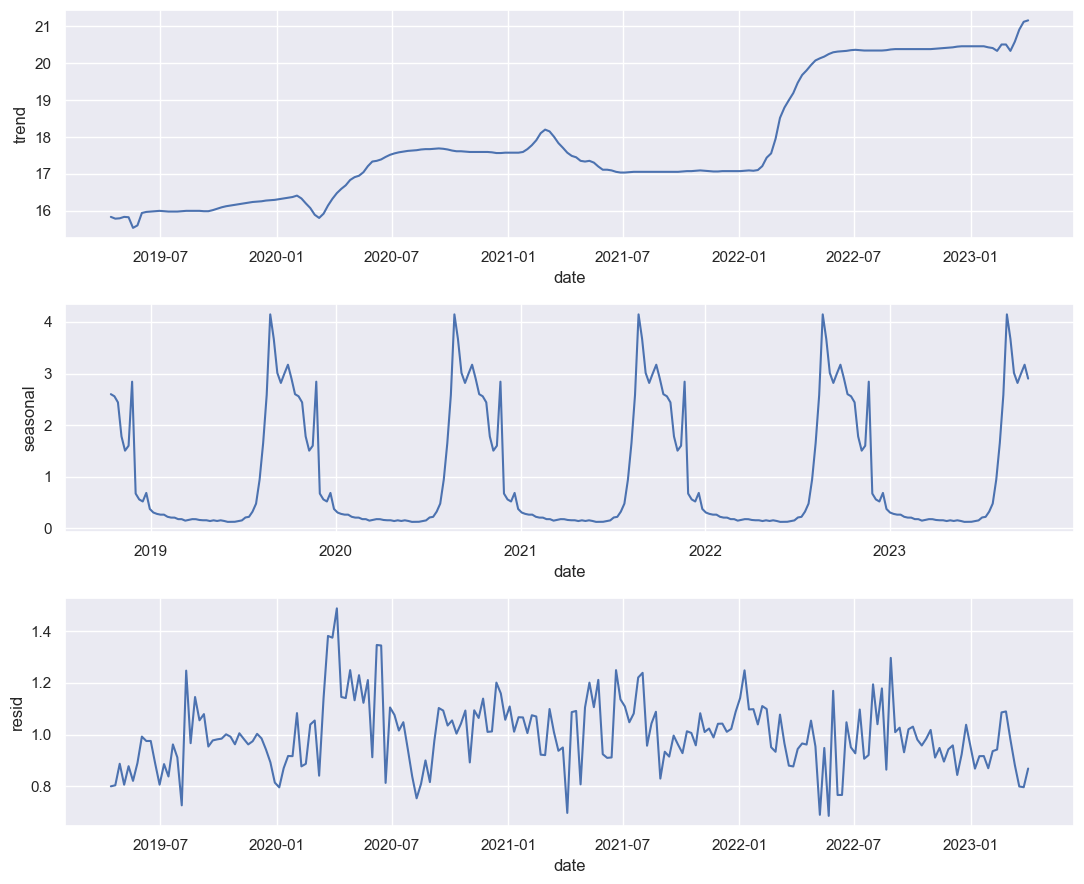

In [8]:
seasonal_decomp(df, 'multiplicative')                             # Trying out a multiplicative model, which will hopefully have a much smaller scale in residuals

Observations: The residuals are now on a much smaller scall and have a lot more randomness to their spread. The residuals being so small is good evidance that this data has strong potential for predictive modeling. 

## Train Test Split

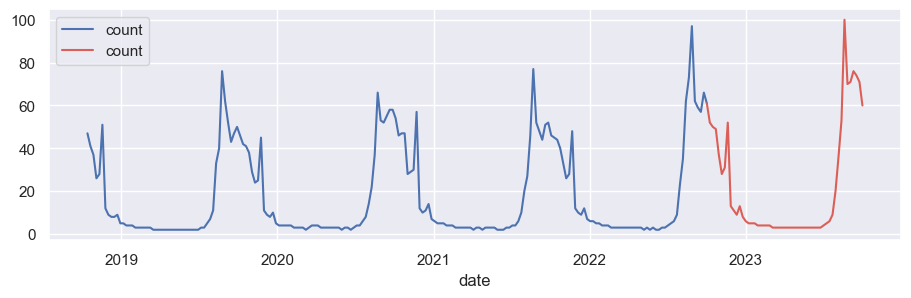

In [9]:
sns.set(rc={'figure.figsize':(11,3)})                         # Reformatting the plot       
train = df[:-52]                                              # Making the training set
test = df[-53:]                                               # Making the test set
sns.lineplot(train)                                           # Visualizing the split to ensure no errors
sns.lineplot(test, palette = 'hls');                          # Making the test data red 

No errors in the train test split

## ACF and PACF plots for SARIMA modeling

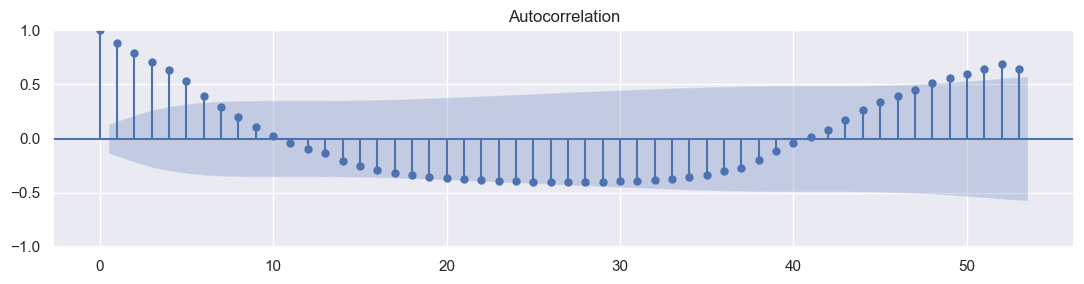

In [10]:
plot_acf(train, lags = 53)                                   # Testing out up to 52 lags to see if last year's data is a good predictor
plt.tight_layout()                                           # 53 lags to make sure the correlation goes back down after a year

Observations: strong colrelation on first, second, third, fourth, and fifty second lag, a strong case for a MA term of 1,

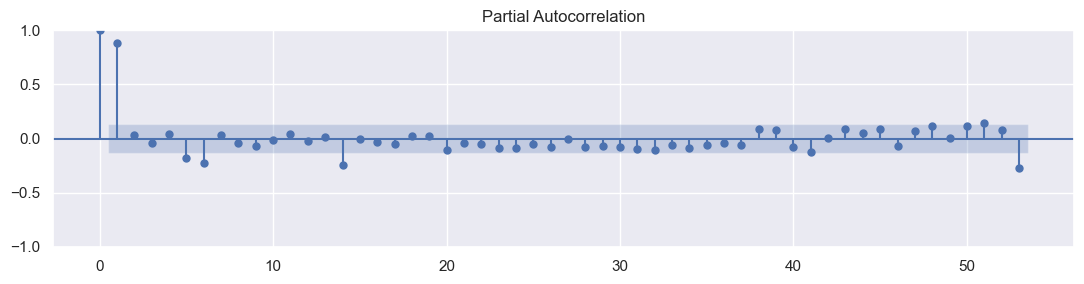

In [11]:
plot_pacf(train, lags = 53)
plt.tight_layout()

Observations: we should definately try a AR term of 1. 

Expected Order of a SARMA model: ((1, 0, 1 or 2 or 3 or 4 or 52), (?, ?, ?, 52))

# Naive model: weekly
Using last week's data as a direct prediction of this week's data as the model to beat for statistical significants

In [12]:
n_preds = df.shift(1)[-53::]                             # Shifting the data forward by one week
n_preds.info()                                           # Checking the index of the naive predictions

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2022-10-02 to 2023-10-01
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   53 non-null     float64
dtypes: float64(1)
memory usage: 848.0 bytes


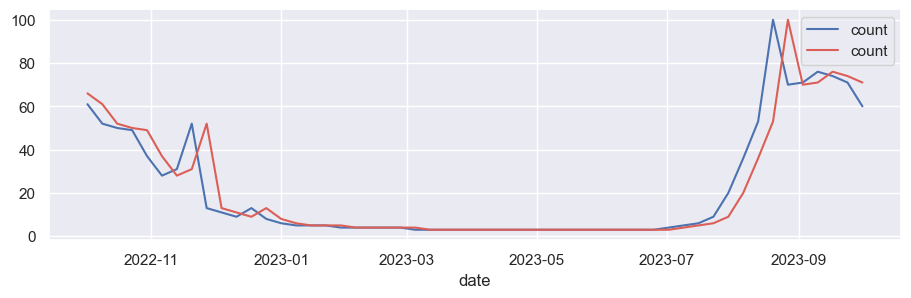

MAPE: 18.126261756998016 
RMSE: 10.911306235899756


In [13]:
# fix start date on red line

seasonal_metrics_graph(test, n_preds)                              # Seeing how our naive model performs

Observations: True, shown in blue and predited using a naive model of last weeks data shown in red. 

# Naive model: yearly
Using last year's data as a direct prediction of this week's data as the model to beat for statistical significants

In [14]:
n_preds = df.shift(52)[-53::]                             # Shifting the data forward by one week
n_preds.info()    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2022-10-02 to 2023-10-01
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   53 non-null     float64
dtypes: float64(1)
memory usage: 848.0 bytes


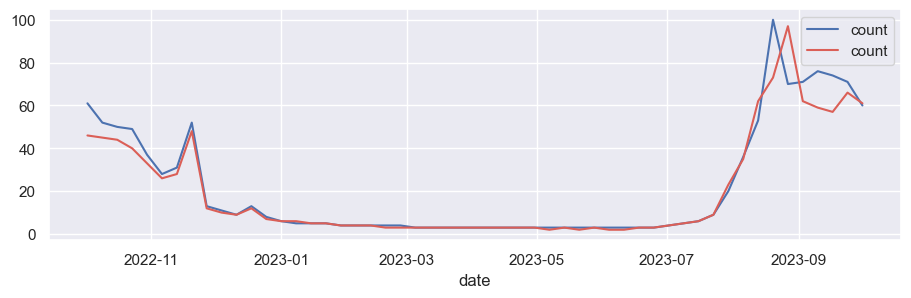

MAPE: 11.793489106666508 
RMSE: 7.112306634304891


In [15]:
seasonal_metrics_graph(test, n_preds) 

Observations: last week's data wasn't as predictive of this week's data as last year's data. 11% MAPE/7.11 RMSE will be the score to beat with my other models. 

# SARMA

Trying a SARMA model based on inference from ACF and PACF plots

In [16]:
y_true = test[1::]                 # Shifting our test data over by one week to match the prediction index for SARMA models
y_true.info()                        # Checking the index (it will start before our naive model, which I am okay with but isn't ideal for comparison.)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2022-10-09 to 2023-10-01
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   52 non-null     int64
dtypes: int64(1)
memory usage: 832.0 bytes


### Rational behind testing for "c", "t", and "ct":

The data has a multiplicative relationship to time, therefore if a SARIMA model to be able to account for that, we must try adding multipliers to the trendline, or a combination of a multipyer and an exponent (polynomial trendline.) 

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

trendstr{‘n’,’c’,’t’,’ct’} or iterable, optional
Parameter controlling the deterministic trend polynomial 
. Can be specified as a string where ‘c’ indicates a constant (i.e. a degree zero component of the trend polynomial), ‘t’ indicates a linear trend with time, and ‘ct’ is both. Can also be specified as an iterable defining the non-zero polynomial exponents to include, in increasing order. For example, [1,1,0,1] denotes 
. Default is to not include a trend component.

_______________________________________________________________________________
      Trend = n
 ORDER : (52, 0, 1), (0, 0, 0, 52)


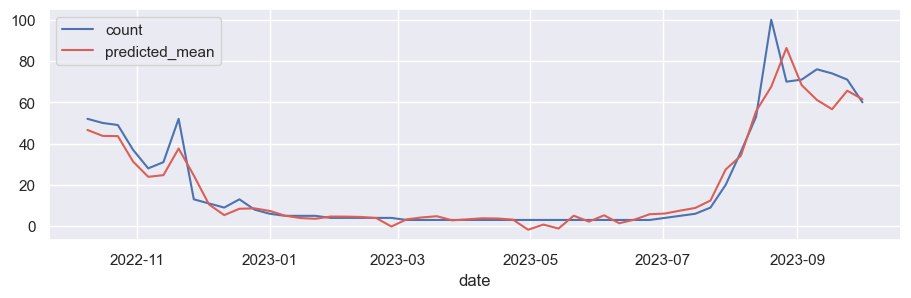

MAPE: 88.72107354686321 
RMSE: 7.110417973757452
_______________________________________________________________________________
      Trend = c
 ORDER : (52, 0, 1), (0, 0, 0, 52)


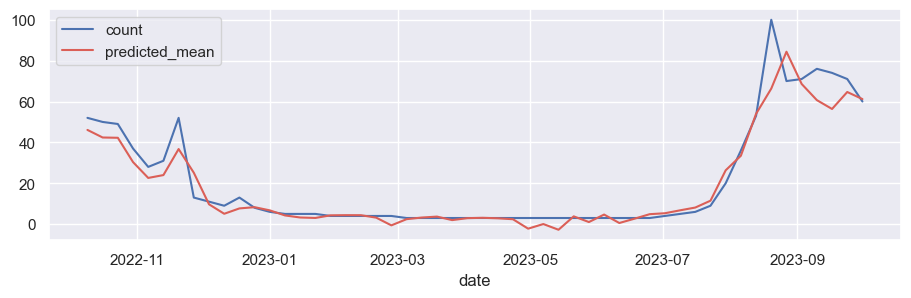

MAPE: 184.06553347465194 
RMSE: 7.340788310899194
_______________________________________________________________________________
      Trend = t
 ORDER : (52, 0, 1), (0, 0, 0, 52)


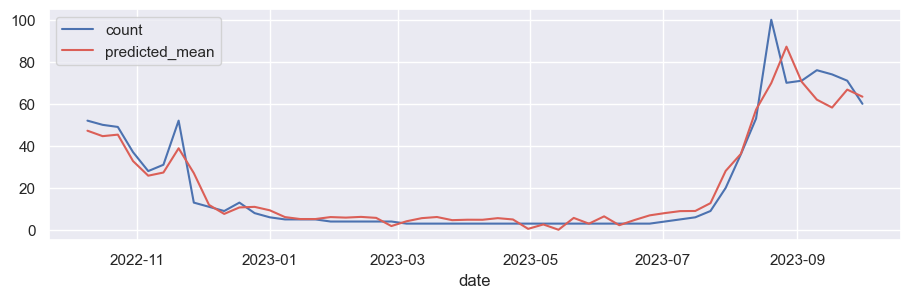

MAPE: 103.38655121215771 
RMSE: 6.837189317186641
_______________________________________________________________________________
      Trend = ct
 ORDER : (52, 0, 1), (0, 0, 0, 52)


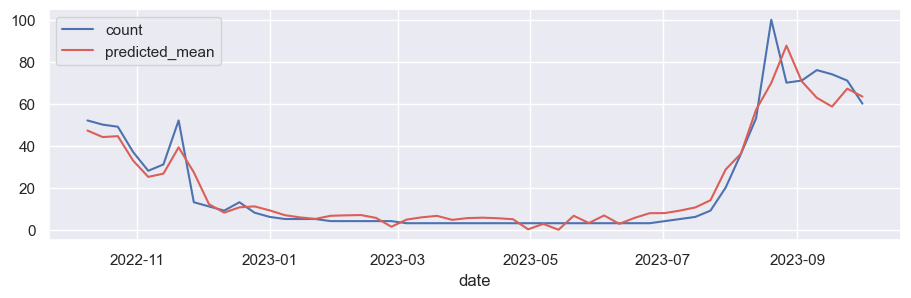

MAPE: 136.73503863335955 
RMSE: 6.932282334243966
_______________________________________________________________________________
      Trend = None
 ORDER : (52, 0, 1), (0, 0, 0, 52)


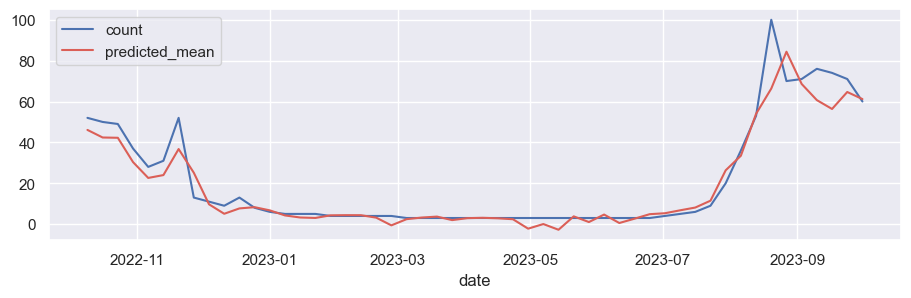

MAPE: 184.06553347465194 
RMSE: 7.340788310899194


In [17]:
sarima(train, y_true, (52, 0, 1), (0, 0, 0, 52)) 

Trend = t

ORDER : (52, 0, 1), (0, 0, 0, 52) 

MAPE: 103.38655121215771 

RMSE: 6.837189317186641

This model has a higher MAPE and a lower RMSE than both of our naive models and I'll continue to test models to try and beat this iteration. 

_______________________________________________________________________________
      Trend = n
 ORDER : (52, 0, 0), (0, 0, 0, 52)


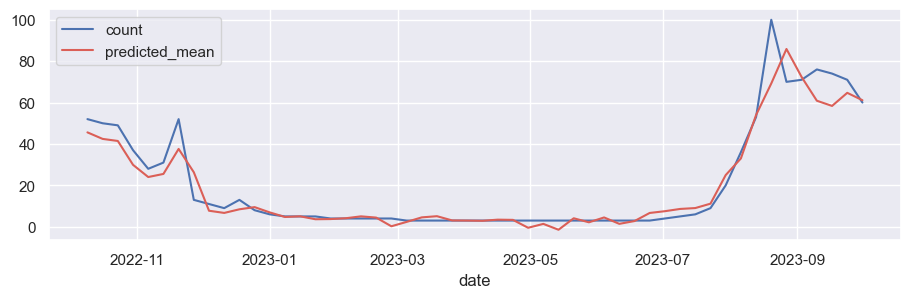

MAPE: 73.83947977980291 
RMSE: 6.994879923291195
_______________________________________________________________________________
      Trend = c
 ORDER : (52, 0, 0), (0, 0, 0, 52)


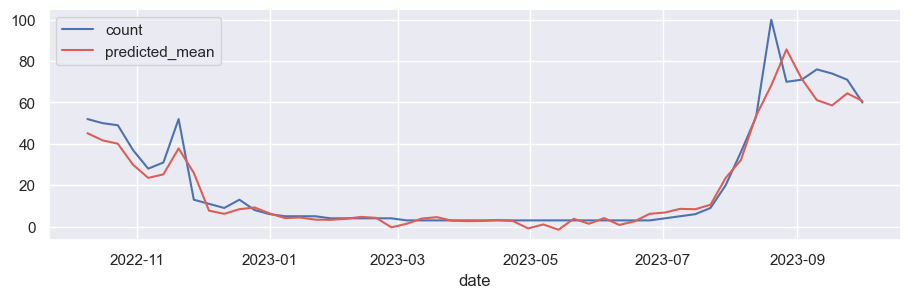

MAPE: 69.8692469322397 
RMSE: 7.083333497011354
_______________________________________________________________________________
      Trend = t
 ORDER : (52, 0, 0), (0, 0, 0, 52)


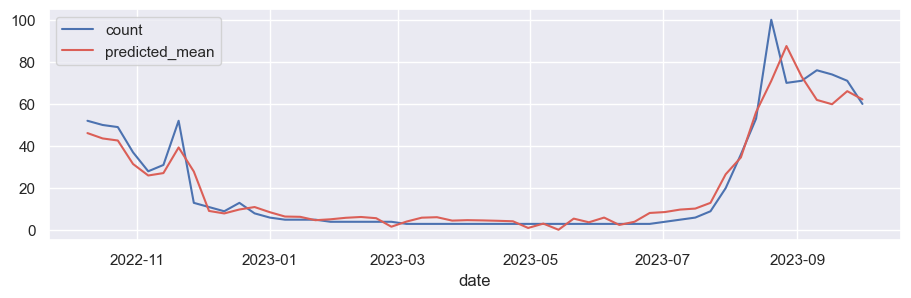

MAPE: 56.19114709969264 
RMSE: 6.799070099253735
_______________________________________________________________________________
      Trend = ct
 ORDER : (52, 0, 0), (0, 0, 0, 52)


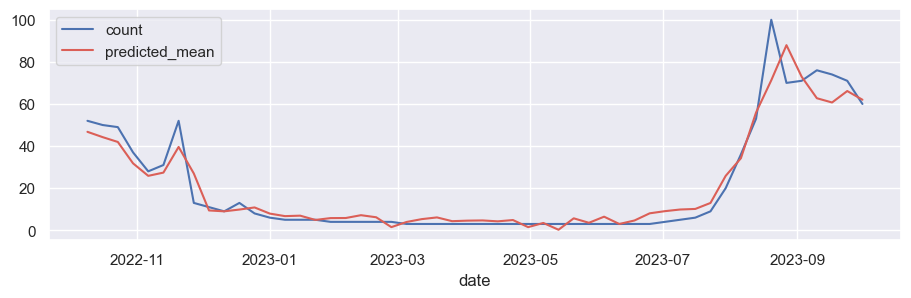

MAPE: 50.83148809824001 
RMSE: 6.665186584253931
_______________________________________________________________________________
      Trend = None
 ORDER : (52, 0, 0), (0, 0, 0, 52)


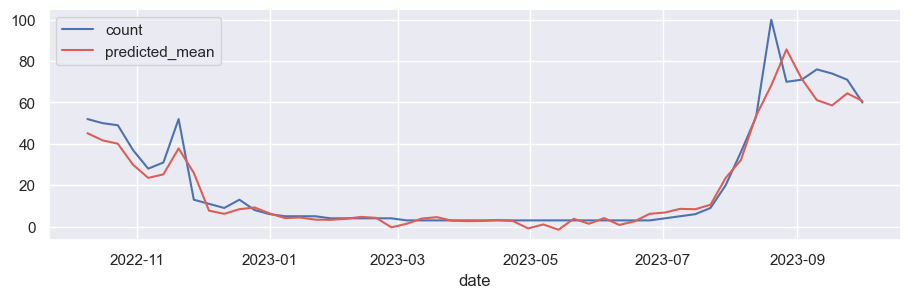

MAPE: 69.8692469322397 
RMSE: 7.083333497011354


In [18]:
sarima(train, y_true, (52, 0, 0), (0, 0, 0, 52))

Observations: The following model outperformed my last best model in both MAPE score and RMSE.

Trend = ct

ORDER : (52, 0, 0), (0, 0, 0, 52) 

MAPE: 50.83148809824001 

RMSE: 6.665186584253931

Next I'll try different parameters in the trend to see if we can't improve the RMSE. 

## Rational for experimenting with seasonal auto regressive and seasonal moving average terms: 

Per this article:https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa

"""

(P,D,Q,M) Order
The (P,D,Q,M) Order refers to the seasonal component of the model for the Auto Regressive parameters, differences, Moving Average parameters, and periodicity:

D indicates the integration order of the seasonal process (the number of transformation needed to make stationary the time series)
P indicates the Auto Regressive order for the seasonal component
Q indicated the Moving Average order for the seasonal component
M indicates the periodicity, i.e. the number of periods in season, such as 12 for monthly data.

"""

During seasonal decomposition, there was still a yearly dip in the overall trend line, therefore I need to try and capture that relationship with P and Q. I already know M to be 52 (the number of data points in a cycle.) And I didn't transform the data to make it stationary. The next model I'll try will have 0s in the first three terms and a SEASONAL AR (P) term of 1 and 52 for M. This will be pretty close to simply using last year's data, except it leaves the option for adding some noise with the constant, trendline and constant + trendline features. 

_______________________________________________________________________________
      Trend = n
 ORDER : (0, 0, 0), (1, 0, 0, 52)


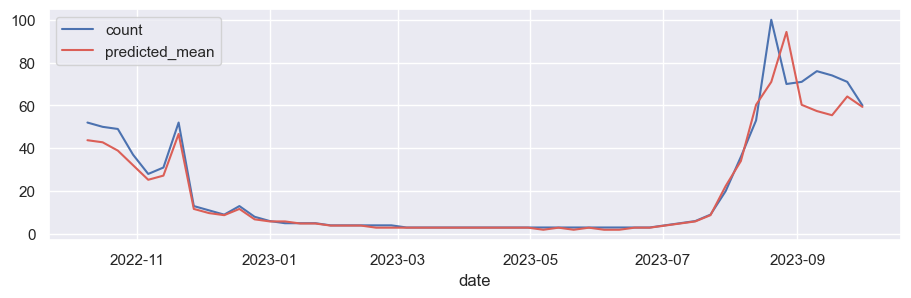

MAPE: 14.064695059733385 
RMSE: 7.154015696359476
_______________________________________________________________________________
      Trend = c
 ORDER : (0, 0, 0), (1, 0, 0, 52)


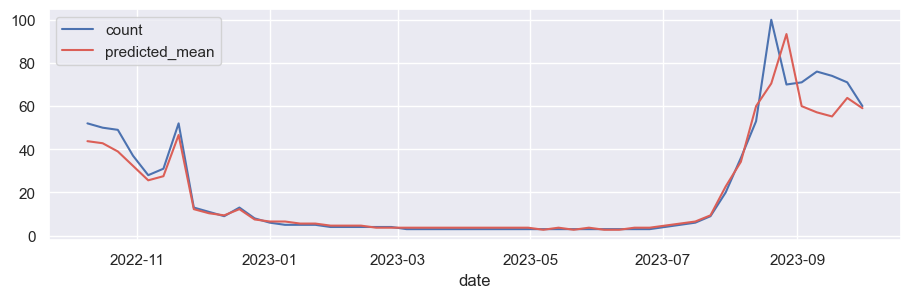

MAPE: 14.623164562273047 
RMSE: 7.159920967223625
_______________________________________________________________________________
      Trend = t
 ORDER : (0, 0, 0), (1, 0, 0, 52)


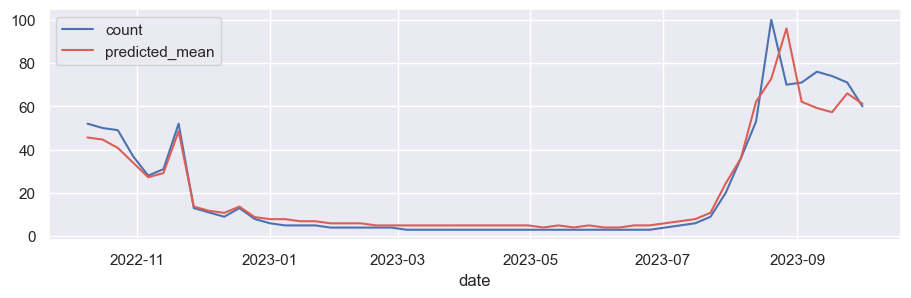

MAPE: 24.518892132144245 
RMSE: 6.873744890331798
_______________________________________________________________________________
      Trend = ct
 ORDER : (0, 0, 0), (1, 0, 0, 52)


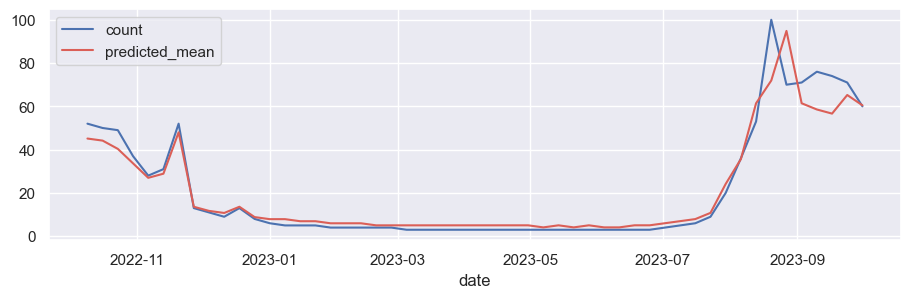

MAPE: 24.93553626489064 
RMSE: 6.969358458340892
_______________________________________________________________________________
      Trend = None
 ORDER : (0, 0, 0), (1, 0, 0, 52)


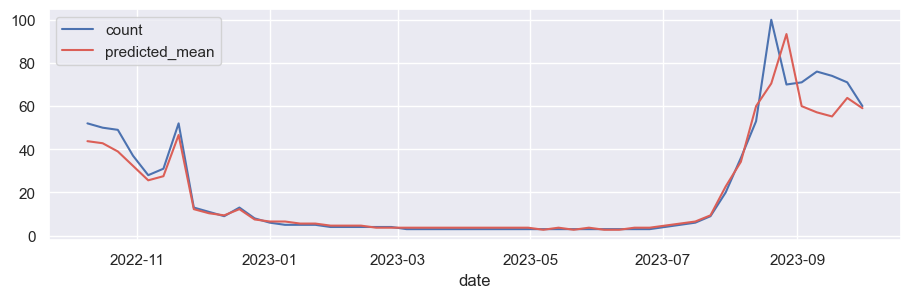

MAPE: 14.623164562273047 
RMSE: 7.159920967223625


In [19]:
sarima(train, y_true, (0, 0, 0,), (1, 0, 0, 52))

Observations: None of these models could outperform my best model tested so far of: 

Trend = ct

ORDER : (52, 0, 0), (0, 0, 0, 52) 

MAPE: 50.83148809824001 

RMSE: 6.665186584253931

## Rational for experimenting with last year's data + noise 

In a SARIMA model, I have the option of experimenting with the seasonal autoregresive feature (AR in the season ie the number of lags) and the moving average feature (MA in the season or amount of noise.) A SARIMA model with the order of 0, 0, 0, 1, 0, 1, 52 will compare last year's data + noise on a cycle of 52 weeks. This will be very similar to our yearly naive model (just use last year's data to predict this year) 

_______________________________________________________________________________
      Trend = n
 ORDER : (0, 0, 0), (1, 0, 1, 52)


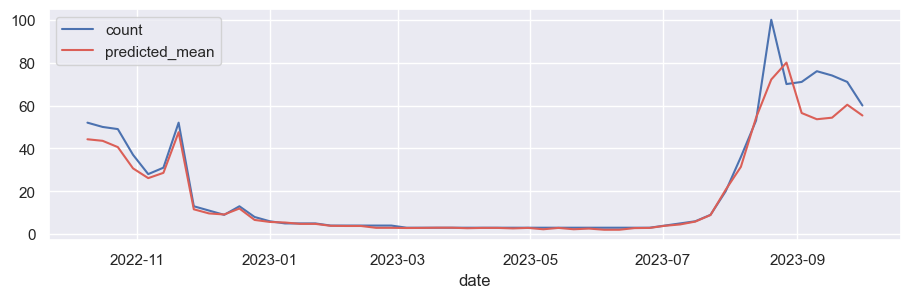

MAPE: 13.537786220377745 
RMSE: 6.778890483879696
_______________________________________________________________________________
      Trend = c
 ORDER : (0, 0, 0), (1, 0, 1, 52)


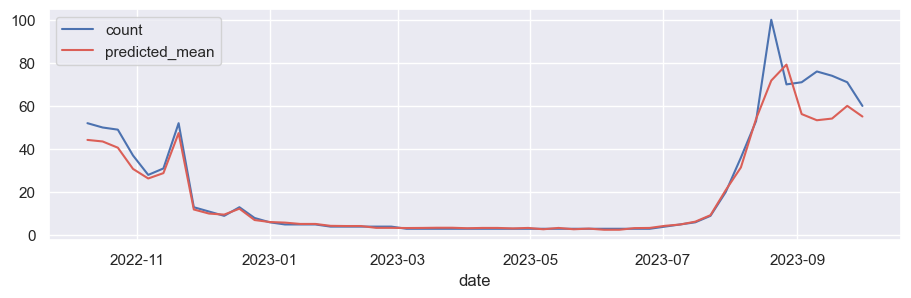

MAPE: 11.995450471625256 
RMSE: 6.821775126445359
_______________________________________________________________________________
      Trend = t
 ORDER : (0, 0, 0), (1, 0, 1, 52)


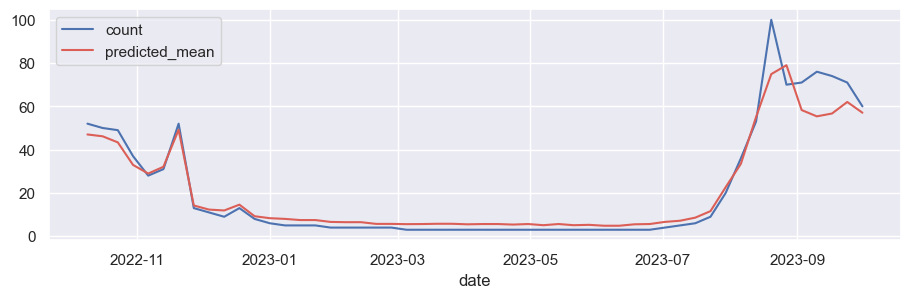

MAPE: 28.70955520746044 
RMSE: 6.19925042577593
_______________________________________________________________________________
      Trend = ct
 ORDER : (0, 0, 0), (1, 0, 1, 52)


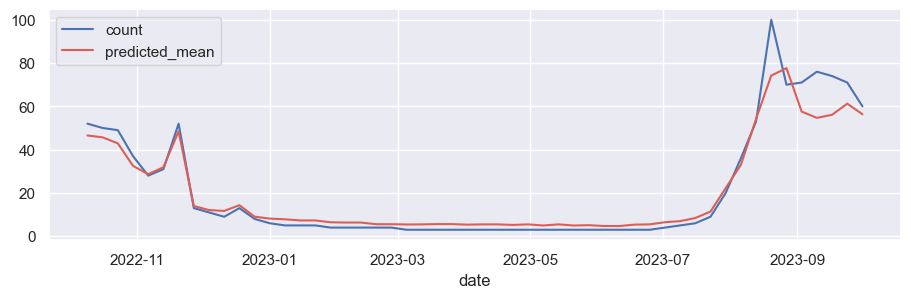

MAPE: 27.82715716234089 
RMSE: 6.3414036029083345
_______________________________________________________________________________
      Trend = None
 ORDER : (0, 0, 0), (1, 0, 1, 52)


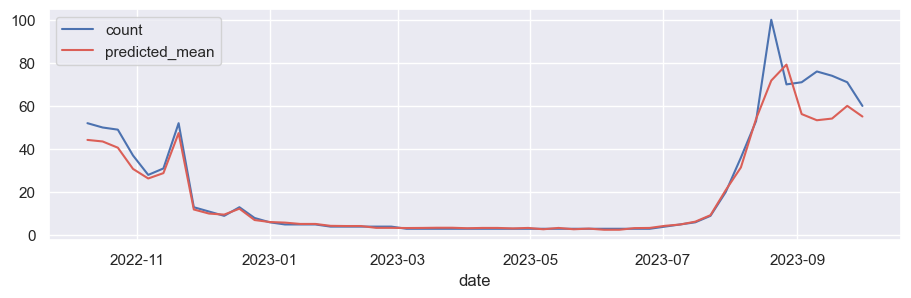

MAPE: 11.995450471625256 
RMSE: 6.821775126445359


In [20]:
sarima(train, y_true, (0, 0, 0), (1, 0, 1, 52))

Observations: 

**I have a new contender for best model:** 

Trend = t

ORDER : (0, 0, 0), (1, 0, 1, 52)

MAPE: 28.70955520746044 

RMSE: 6.19925042577593

This model is essentially using last year's data as the SEASONAL AR (autoregressive/P) term and a SEASONAL MA (moving average/Q) term of 1 to add noise. It runs using a 52 week cycle (M). 

## Rational for trying auto arima

Auto arima is a itterative approach to getting the best possible terms in a SARIMA model. I'll be using a random seed in order to test iterations of terms. Auto arima may have some redundant testing, however, and will be using AIC which is a different metric to track goodness of fit. However, I think it's worth it to see what auto arima can come up with. I'll be using randomness instead of a linear stepwise function as the relationship is multiplicative and randomness will help me account for that as opposed to using all my iterations on a smaller subsection of possibilities. Lots of people will only use auto arima and not try to use their findings from ACF and PACF plots, however I want to ensure I'm using all tools available to me to get my SARIMA model as close as possible. 

In [21]:
sarima_model_params = pm.arima.auto_arima(train, m = 52, trace = True, # setting m to 52 as that's the 
                                          random = True, n_jobs= -1)   # number of periods in a cycle and
sarima_model_params                                                    # setting n_jobs to -1 to be exhaustive

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=1409.256, Time=4.71 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1862.861, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1968.638, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=1403.707, Time=3.74 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=1522.636, Time=0.06 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=1404.494, Time=145.53 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=1409.375, Time=217.39 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=1411.384, Time=1.66 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=1411.642, Time=1.73 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=1415.592, Time=4.40 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=1404.029, Time=4.23 sec
 ARIMA(1,0,1)(1,0,0)[52] inter

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 0, 0, 52),
      suppress_warnings=True)

_______________________________________________________________________________
      Trend = n
 ORDER : (2, 0, 2), (1, 0, 0, 52)


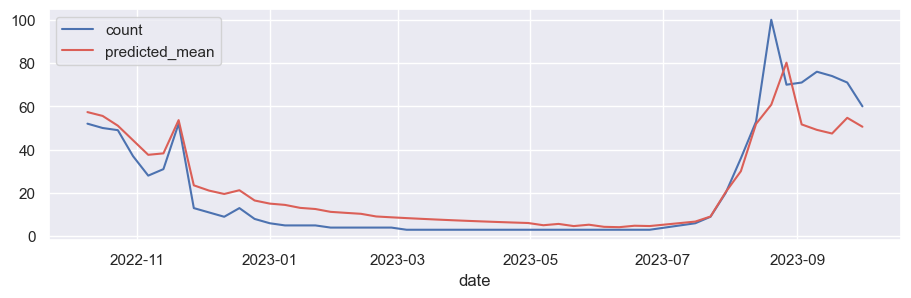

MAPE: 39.363336571843796 
RMSE: 10.041930268424773
_______________________________________________________________________________
      Trend = c
 ORDER : (2, 0, 2), (1, 0, 0, 52)


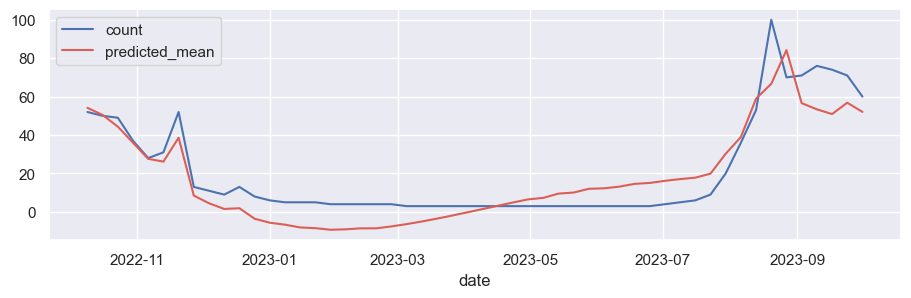

MAPE: 126.50212969093342 
RMSE: 11.148105078013648
_______________________________________________________________________________
      Trend = t
 ORDER : (2, 0, 2), (1, 0, 0, 52)


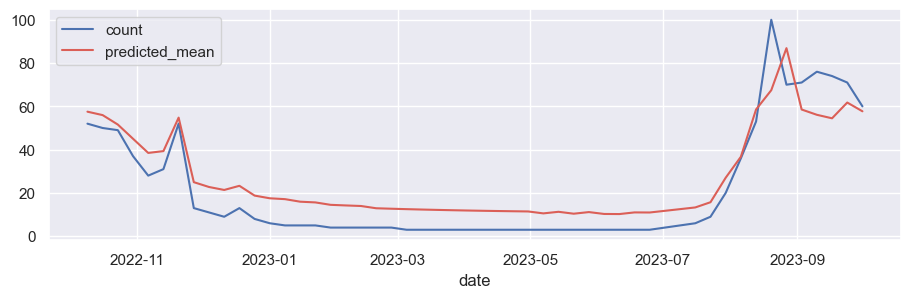

MAPE: 51.39003181095022 
RMSE: 10.585201519933813
_______________________________________________________________________________
      Trend = ct
 ORDER : (2, 0, 2), (1, 0, 0, 52)


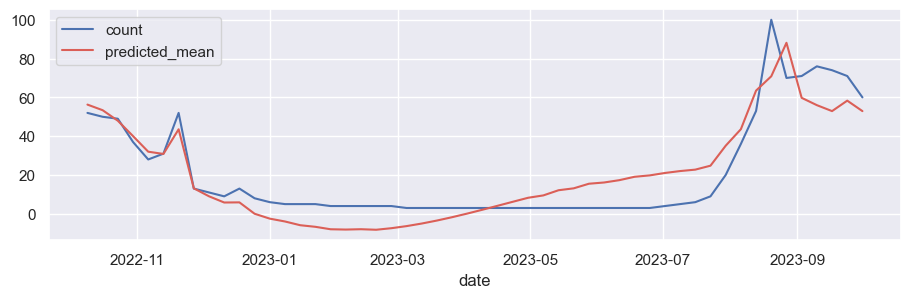

MAPE: 670.8665351669166 
RMSE: 11.441487548179497
_______________________________________________________________________________
      Trend = None
 ORDER : (2, 0, 2), (1, 0, 0, 52)


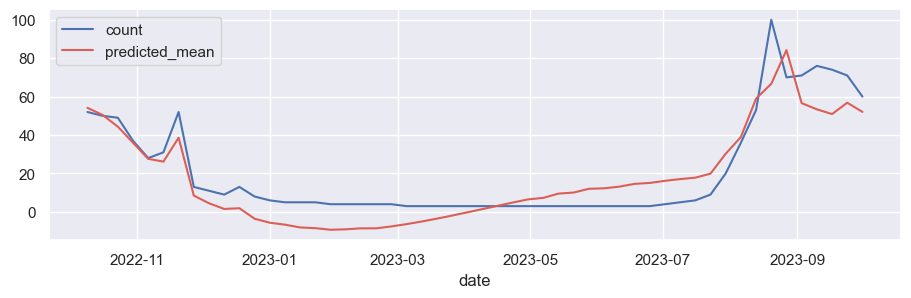

MAPE: 126.50212969093342 
RMSE: 11.148105078013648


In [22]:
sarima(train, y_true, (2, 0, 2), (1, 0, 0, 52))

Observations: This model did worse than our current contender model, many of these models not doing better than our naive model. It's worth noting that auto arima has not made ACF and PACF plots redundant in this case. My models that were built on inference based on those plots have performed better than a brute force approach to finding performant terms. 

# ETS

In [23]:
ets_1 = ExponentialSmoothing(train, use_boxcox = True, seasonal = 'multiplicative', 
                             seasonal_periods = 52, ).fit()

In [24]:
preds = pd.DataFrame(ets_1.forecast(52))
preds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2022-10-09 to 2023-10-01
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       52 non-null     float64
dtypes: float64(1)
memory usage: 832.0 bytes


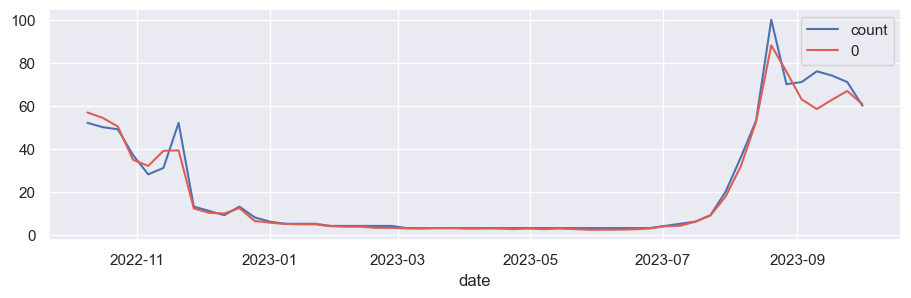

MAPE: 12.118428034881385 
RMSE: 4.429939957414803


In [27]:
seasonal_metrics_graph(y_true, preds)

**We've disproved the null hypothesis!**


Observations: This model does very well, and is the best model I've tested. Using an ETS model here was much more effective than using the 'ct' functionality in a linear model. It's more performant than using last week's or last year's data, and it's especially good at being true to upward fall spikes. It's comparible in MAPE score to the yearly naive model and has a better RMSE, reducing by a little less than half. 

# Conclusion 

We've proved that pumpkin spice popularity on Google is very seasonal and can be predicted. Between naive, SARMA models, and ETS models, ETS was better able to capture the relationship between time and Pumpkin Spice popularity. The multiplicative relationship of pumpkin spice to time implies that pumpkin spice's popularity is based on more than one independant variable besides time in the expression time * unknown_independant_var = pumpkin_spice_popularity. It also could represent the exponential influence that current pumpkin spice users are having on non pumpkin spice users to become pumpkin spice users, as it's more likley than the amount of pumpkin spice users remaining constant and googling pumpkin spice at exponentially increasing rates. 

# Next steps 

I'll come back to this project again on 10/7/2024 and see how my SARIMA model predicted the last year. 

# What I learned

In the future, if the seasonal decomposition is showing lower residuals for either a multiplicative or exponential model, I'll try an ETS before I try a SARIMA type of model, which are optimised for data where an additive model had lower residuals than the other two types. It will probably save me time and effort in the future. 

# Saving the Model for validation on 10/7/2024

In [ ]:
#filename = 'pumpkin_spice_predictor.sav'
#pickle.dump(ets_1, open(filename, 'wb'))

See my validation notebook for my work in validating this model on data I've not seen during my process. 